<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow
**Transfer Learning**: Taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.
_Advantages_
1. Can leverage the architecture of the model proven to work on similar problem as ours.
2. Can leverage the working neural network architecture which has already learned patterns on data similar to our own. This results in achieving great results.

### What we will cover
1. Introduce **Transfer Learning**
2. Using a smaller dataset to experiment faster
3. Build a transfer learning feature extraction model using Tensorflow hub.
4. Introduce a **TensorBoard** callback to track model training results.
5. Compare model results using TensorBoard

In [1]:
# Add datetime
import datetime
print(f" Notebook last run end-to-end: {datetime.datetime.now()}")

 Notebook last run end-to-end: 2023-08-02 22:21:43.825388


In [2]:
!nvidia-smi

Wed Aug  2 22:21:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Transfer learning with Tensorflow hub: Getting great results with 10% data

### Downloading and becoming one with data

In [3]:
# Get data ( 10% label)
import zipfile

#Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/10_food_classes_10_percent.zip","r")
zip_ref.extractall()
zip_ref.close()

--2023-08-02 22:21:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.199.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   141MB/s    in 1.1s    

2023-08-02 22:21:45 (141 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
!rm -r /content/__MACOSX

In [5]:
# How many images in each folder
import os

for dirpath,dirname,filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f" There are {len(dirname)} directories and {len(filenames)} images at location :{dirpath}")

 There are 2 directories and 0 images at location :/content/10_food_classes_10_percent
 There are 10 directories and 0 images at location :/content/10_food_classes_10_percent/test
 There are 0 directories and 250 images at location :/content/10_food_classes_10_percent/test/hamburger
 There are 0 directories and 250 images at location :/content/10_food_classes_10_percent/test/chicken_wings
 There are 0 directories and 250 images at location :/content/10_food_classes_10_percent/test/steak
 There are 0 directories and 250 images at location :/content/10_food_classes_10_percent/test/grilled_salmon
 There are 0 directories and 250 images at location :/content/10_food_classes_10_percent/test/pizza
 There are 0 directories and 250 images at location :/content/10_food_classes_10_percent/test/fried_rice
 There are 0 directories and 250 images at location :/content/10_food_classes_10_percent/test/sushi
 There are 0 directories and 250 images at location :/content/10_food_classes_10_percent/test/

### Creating Dataloaders (preparing the data)


In [6]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE= (224,224)
BATCH_SIZE= 32

train_dir= "/content/10_food_classes_10_percent/train"
test_dir= "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print(" Training images.")
train_10_percent_data= train_datagen.flow_from_directory(train_dir
                                                         ,target_size=IMAGE_SHAPE
                                                         ,batch_size=BATCH_SIZE
                                                         ,class_mode="categorical")

print(" Test images")
test_10_percent_data= test_datagen.flow_from_directory(test_dir
                                                       ,target_size=IMAGE_SHAPE
                                                       ,batch_size=BATCH_SIZE
                                                       ,class_mode="categorical")


 Training images.
Found 750 images belonging to 10 classes.
 Test images
Found 2500 images belonging to 10 classes.


### Setting up the callbacks
**[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)** are extra functionality that can be added to models which can be executed during or after or start of the training.

We will see how to use Tensorboard callback to track experiments. The Tensorboard callback can be accessed using `tf.keras.callbacks.Tensorboard()`
Its main functionality is saving model's training performance metrics to a specified `log_dir`

In [7]:
import tensorflow as tf
SAVE_DIR="model_logs"

In [8]:
# create tensorboard callback
import tensorflow as tf

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  return tf.keras.callbacks.TensorBoard(log_dir=log_dir)

## Creating models using [Tensorflow hub](https://www.tensorflow.org/hub)

We will use the following models from the hub:
1. ResNetV2- 2016 state of the art computer vision model architecture.
2. EfficientNet: 2019 state of the art computer vision model architecture.

1. **As is, Transfer Learning** is when we take pretrained model as it is and apply it to our task without any changes.
  Say, we have problem where we want to classify the image across 1000 different classes of images, we can use this kind of Transfer Learning.Models with `/classification` in their name on Tensorflow hub provide this kind of functionality
2. **Feature Extraction Transfer Learning** is when we take underlying patterns of a pretrained model and adjust its output to fit our problem statement.
  For example, we have images which can be classified across 10 classes and we pick up a model which has been trained on ImageNet and can classify a image across 1000 classes. In such scenario, we just train few upper layers by changing the original activation layer which resembles the number of classes suitable to our problem. The important part is **only a few top layers become trainable, rest remains frozen**.
3. **Fine-tune transfer Learning** is when we take the underlying patterns (also called weights) and adjust to our problem statement. This usually means training **some, many or all** of the layers in the model.

In [9]:
## import libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


Now we will use the feature vectors from 2 popular vision architectures. [EfficientNetB0](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) and [ResNetV250](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4).

In [10]:
# EfficientnetB0 V2 feature vector
effnet_url= "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

# Resnet 50 V2 feature vector
resnet_url= "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"


In [11]:
def create_model(model_url,num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it

  Args:
    model_url(src): A Tensoflow Hub feature extraction url.
    num_classes: Number of output neurons in output layer,
     should be equal to number of classes , default=10
  Returns:
    A uncompiled keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs
  """
  # Download the pre-trained model and save it as keras layer

  feature_extraction_layer= hub.KerasLayer(model_url
                                           ,trainable=False
                                           ,name="feature_extraction_layer"
                                           ,input_shape=IMAGE_SHAPE+(3,))

  #Create our own model
  model= tf.keras.Sequential([
      feature_extraction_layer
      ,layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model

In [12]:
resnet_model= create_model(resnet_url)

resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy
                     ,optimizer=tf.keras.optimizers.Adam()
                     ,metrics=["accuracy"])


In [13]:
resnet_history= resnet_model.fit(train_10_percent_data
                                 ,epochs=5
                                 ,steps_per_epoch=len(train_10_percent_data)
                                 ,validation_data=test_10_percent_data
                                 ,validation_steps=len(test_10_percent_data)
                                 ,callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet_50")]
                                 )

Epoch 1/5
24/24 [==============================] - 27s 569ms/step - loss: 1.8357 - accuracy: 0.4067 - val_loss: 1.1927 - val_accuracy: 0.6256
Epoch 2/5
24/24 [==============================] - 11s 472ms/step - loss: 0.9066 - accuracy: 0.7253 - val_loss: 0.8649 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 12s 523ms/step - loss: 0.6207 - accuracy: 0.8400 - val_loss: 0.7558 - val_accuracy: 0.7552
Epoch 4/5
24/24 [==============================] - 11s 473ms/step - loss: 0.4785 - accuracy: 0.8973 - val_loss: 0.7083 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 13s 547ms/step - loss: 0.3845 - accuracy: 0.9133 - val_loss: 0.7019 - val_accuracy: 0.7648


Let's create a function to plot the loss curves

In [16]:
import matplotlib.pyplot as plt

def plot_loss_curve(history):
  """
    Returns separate loss curve for training and validation metrics

  """
  loss= history.history["loss"]
  val_loss= history.history["val_loss"]

  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]

  epochs= range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs,loss,label="train loss")
  plt.plot(epochs,val_loss,label="test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="train accuracy")
  plt.plot(epochs,val_accuracy,label="test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

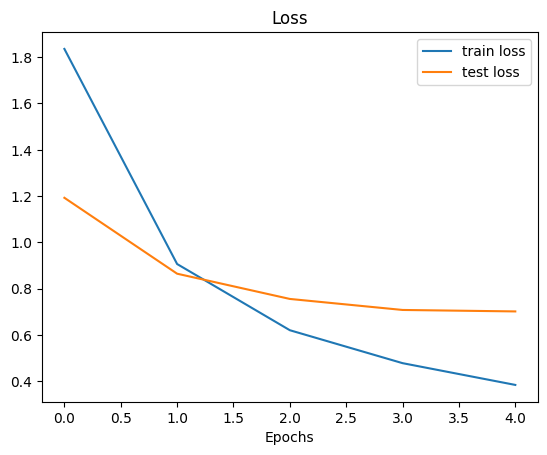

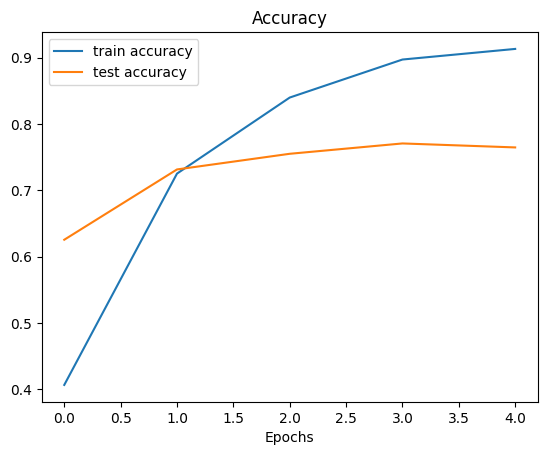

In [17]:
plot_loss_curve(resnet_history)

In [18]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Lets execute the same set of experiments with efficientnet_B0 model

In [19]:
effnet_model= create_model(effnet_url
                           ,num_classes=train_10_percent_data.num_classes)

effnet_model.compile(loss=tf.keras.losses.categorical_crossentropy
                     ,optimizer=tf.keras.optimizers.Adam()
                     ,metrics=["accuracy"])


In [21]:
effnet_history= effnet_model.fit(train_10_percent_data
                                 ,steps_per_epoch=len(train_10_percent_data)
                                 ,validation_data=test_10_percent_data
                                 ,validation_steps=len(test_10_percent_data)
                                 ,epochs=5
                                 ,callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="effnetb0")]
                                 )

Epoch 1/5
24/24 [==============================] - 21s 605ms/step - loss: 1.7953 - accuracy: 0.4547 - val_loss: 1.2539 - val_accuracy: 0.7488
Epoch 2/5
24/24 [==============================] - 11s 466ms/step - loss: 1.0230 - accuracy: 0.7893 - val_loss: 0.8463 - val_accuracy: 0.8268
Epoch 3/5
24/24 [==============================] - 10s 445ms/step - loss: 0.7335 - accuracy: 0.8320 - val_loss: 0.6828 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 13s 541ms/step - loss: 0.5899 - accuracy: 0.8720 - val_loss: 0.6030 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 10s 448ms/step - loss: 0.4962 - accuracy: 0.8987 - val_loss: 0.5517 - val_accuracy: 0.8600


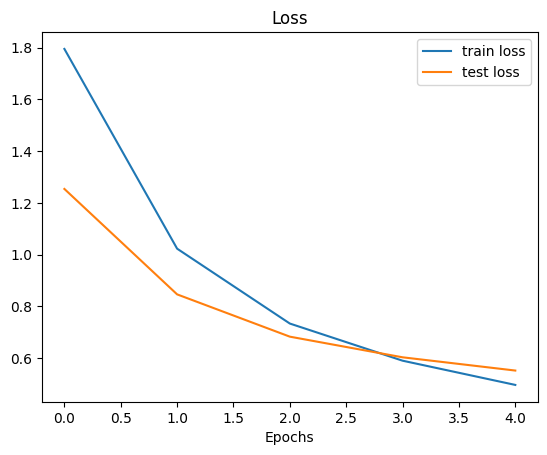

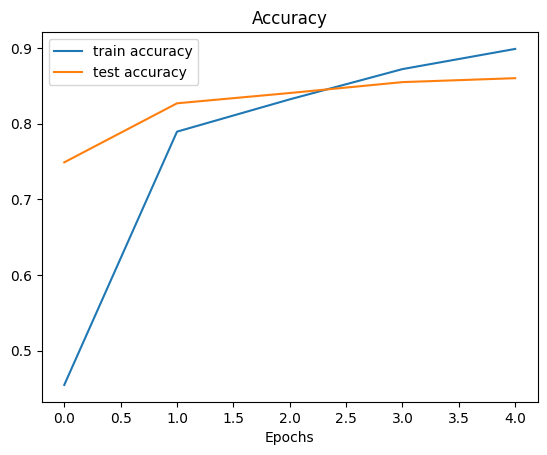

In [22]:
plot_loss_curve(effnet_history)

In [23]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [25]:
# mobilenet v2 feature_vector url
mobilenetv2_url= "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

mobilenetv2_model= create_model(mobilenetv2_url
                                 ,num_classes=train_10_percent_data.num_classes)

mobilenetv2_model.compile(loss=tf.keras.losses.categorical_crossentropy
                          ,optimizer=tf.keras.optimizers.Adam()
                          ,metrics=["accuracy"])



In [26]:
mobilenetv2_history= mobilenetv2_model.fit(train_10_percent_data
                                           ,steps_per_epoch=len(train_10_percent_data)
                                           ,validation_data=test_10_percent_data
                                           ,validation_steps=len(test_10_percent_data)
                                           ,epochs=5
                                           ,callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                   experiment_name="mobilenetv2")])


Epoch 1/5
24/24 [==============================] - 21s 666ms/step - loss: 1.9801 - accuracy: 0.3293 - val_loss: 1.2868 - val_accuracy: 0.6156
Epoch 2/5
24/24 [==============================] - 11s 462ms/step - loss: 1.0160 - accuracy: 0.7080 - val_loss: 0.9153 - val_accuracy: 0.7224
Epoch 3/5
24/24 [==============================] - 10s 419ms/step - loss: 0.7354 - accuracy: 0.8040 - val_loss: 0.7542 - val_accuracy: 0.7764
Epoch 4/5
24/24 [==============================] - 10s 410ms/step - loss: 0.5722 - accuracy: 0.8547 - val_loss: 0.6731 - val_accuracy: 0.7968
Epoch 5/5
24/24 [==============================] - 10s 446ms/step - loss: 0.4745 - accuracy: 0.8853 - val_loss: 0.6321 - val_accuracy: 0.8052


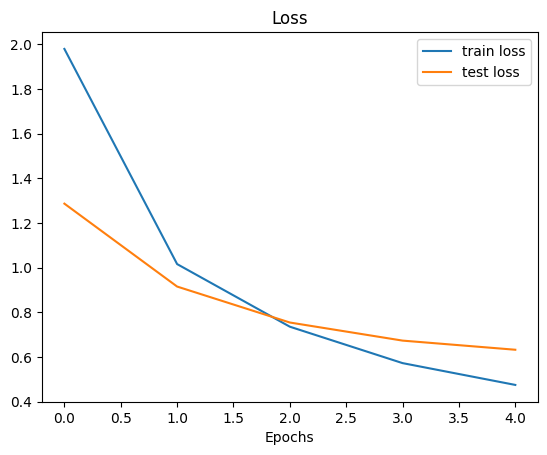

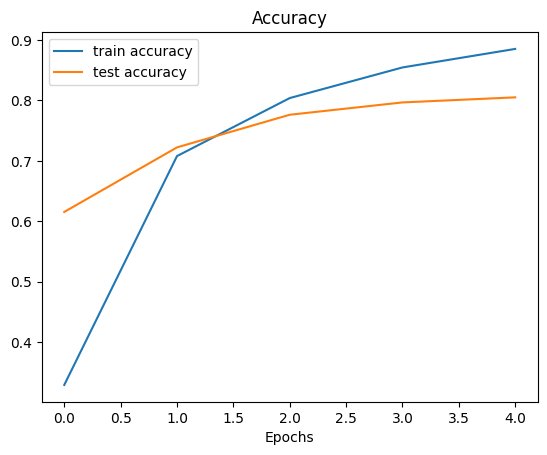

In [27]:
plot_loss_curve(mobilenetv2_history)

In [29]:
!yes | tensorboard dev upload --logdir=/content/tensorflow_hub \
  --name "Effnet vs Mobiblenet vs Resnet" \
  --one_shot

2023-08-02 23:05:48.853203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/tensorflow_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 
To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   KJC-XZY-VSD



New experiment created. View your TensorBoard at: https://tensorboard.dev/